In [139]:
####################################################################
# Stats
import numpy as np
import pandas as pd
from scipy import stats
####################################################################
# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import plotly.graph_objects as go
import seaborn as sns
####################################################################
# General
from pathlib import Path
import os
import pickle
from tqdm import tqdm
from config import model_config
import math
####################################################################
# sklearn
from sklearn.preprocessing import LabelEncoder
####################################################################
# Local packages
from regression import reg

In [140]:
df = pd.read_pickle(Path('../data/df_clean_w_outliers.pkl'))
df['PE_number'] = df.index.get_level_values(0).str[:-2]
print(df.shape)
print(len(df['PE_number'].unique()))
df.head()

(105, 119)
49


,pe_study_number,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,peak_vd_vt,peak_cavo2_a_art_hb,peak_pa_elastance_ea_mmhg_ml_m2,hyperventilation,hyperventilation_num,normal,dob_mask_cl,study_age_cl,study_date_mask_cl,PE_number
PE1_0,PE1,HB046619,M,3.0,174.0,11.931900,0.399756,0.412309,0.326371,0.653708,...,0.130000,0.885970,1.170445,1,1.0,0,1977-12-13,49.886379,2027-11-02,PE1
PE12_0,PE12,HB046622,M,4.0,264.0,0.102822,0.041968,0.000000,0.002098,0.405691,...,0.205714,0.799035,0.540537,1,1.0,0,1986-05-02,45.412731,2031-09-30,PE12
PE12_1,PE12,HB046622,M,2.0,95.0,1.391170,0.000000,0.000000,0.000000,0.114441,...,0.205714,0.799035,0.540537,1,1.0,0,1986-05-02,45.412731,2031-09-30,PE12
PE14_0,PE14,HB046616,F,4.0,111.0,0.825384,0.000000,0.000000,0.000000,0.097104,...,0.210000,0.737339,0.650262,1,1.0,0,1997-04-05,31.616701,2028-11-16,PE14
PE15_0,PE15,HB046618,F,3.0,315.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.260000,0.778135,0.559831,0,0.0,0,2010-08-21,18.699521,2029-05-03,PE15


# Hemodynamic Variable Calculations

In [141]:
# Hemodynamic
df['mpap_co_ratio'] = df['peak_measured_mpap_mmhg'] / df['peak_fick_co']

# Sequence Datawork

In [142]:
def get_n_smallest_date(data, n):
	"""
	:param data: Date column.
	:param n: nth smallest date to return.
	:return: nth smallest date.
	"""
	if data.shape[-1] < n:
		return pd.NaT
	else:
		return data.nsmallest(n, keep='all')[-1]

def calculate_percent_change(data, initial_index, final_index):
	"""
	:param data: Data for group.
	:param initial_index: First patient observation for percent change calculation.
	:param final_index: Last patient observation for percent change calculation.
	:return: Percent change, if two conditions are satisfied:
		- Data exists (first logical condition).
		- Initial observation is not zero (second logical condition) to avoid div by zero.
	"""
	if len(data) > final_index and data.iloc[initial_index] != 0:
		return (data.iloc[final_index] / data.iloc[initial_index]) - 1
	else:
		return np.nan
	
def count_positive_values(row):
    """
    :param row: Row of values to count over.
    :return: Count of positive values. 
    """
    return sum(row > 0)

# Create columns for the nth smallest date
for obs_number in range(1, int(df.pe_obs.max())+1):
	df[f"date_of_obs_{int(obs_number-1)}"] = (
		df
		.groupby('PE_number')['study_date_mask_pe']
		.transform(lambda x: get_n_smallest_date(x, obs_number))
	)
	
# Calculate durations from date to date and percent changes
# Store results in a dictionary to then concat with the original df
# (see https://github.com/pandas-dev/pandas/issues/42477)
dict_of_columns = dict()
for start_obs in range(0, int(df.pe_obs.max())-1):
	for end_obs in range(1, int(df.pe_obs.max())):
		if start_obs >= end_obs:
			continue
		# Calculate durations
		dict_of_columns[f'duration_{start_obs}_to_{end_obs}_days'] = (
			(df[f'date_of_obs_{end_obs}'] - df[f'date_of_obs_{start_obs}']).dt.days
		)
		# Calculate percent changes
		for feature in model_config.num_targets:
			dict_of_columns[f'pct_change_{feature}_{start_obs}_to_{end_obs}'] = (
				df
				.groupby('PE_number')[feature]
				.transform(calculate_percent_change, start_obs, end_obs)
			)
df = pd.concat([df, pd.DataFrame(dict_of_columns)], axis=1)

# Calculate percent change per day
df['pct_change_total_clot_burden_per_day_0_to_1'] = df['pct_change_total_clot_burden_0_to_1'] / df['duration_0_to_1_days']

# Get count of positive clot burden values across all segments 
# Meant to give a sense of the distribution of clot burden
segment_clot_burden_columns = list(set(model_config.num_targets).difference(set(['total_clot_burden'])))
df['num_positive_clot_burden_segments'] = df[segment_clot_burden_columns].apply(count_positive_values, axis=1)

# Check shape
print(f"New shape: {df.shape}")

# Check results
df[[
	'study_date_mask_pe', 
	'date_of_obs_0', 
	'date_of_obs_1', 
	'date_of_obs_2', 
	'date_of_obs_3', 
	'duration_0_to_1_days',
	'duration_0_to_2_days',
	'pct_change_centralartery_0_to_1',
	'num_positive_clot_burden_segments',
]].head(10)

New shape: (105, 458)


,study_date_mask_pe,date_of_obs_0,date_of_obs_1,date_of_obs_2,date_of_obs_3,duration_0_to_1_days,duration_0_to_2_days,pct_change_centralartery_0_to_1,num_positive_clot_burden_segments
PE1_0,2023-10-30,2023-10-30,NaT,NaT,NaT,NaN,NaN,NaN,16
PE12_0,2030-10-10,2030-10-10,2031-09-25,NaT,NaT,350.0,NaN,12.529887,8
PE12_1,2031-09-25,2030-10-10,2031-09-25,NaT,NaT,350.0,NaN,12.529887,2
PE14_0,2028-10-10,2028-10-10,NaT,NaT,NaT,NaN,NaN,NaN,5
PE15_0,2028-01-31,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,NaN,2
PE15_1,2028-08-24,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,NaN,2
PE15_2,2029-03-13,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,NaN,20
PE15_3,2030-07-11,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,NaN,1
PE16_0,2026-10-10,2026-10-10,2026-11-26,NaT,NaT,47.0,NaN,-0.896050,18
PE16_1,2026-11-26,2026-10-10,2026-11-26,NaT,NaT,47.0,NaN,-0.896050,10


In [143]:
print(df['pct_change_total_clot_burden_0_to_1'].mean())
print(df['duration_0_to_1_days'].mean())
print(df['pct_change_total_clot_burden_per_day_0_to_1'].mean())

2.518742749511032
233.22619047619048
-0.013145258695644807


In [144]:
df['num_scans'] = df.groupby('PE_number')['total_clot_burden'].transform('count')

# Additional Date and Duration Datawork 

In [145]:
# Get total number of visits by PE_number
# Can use later to subset into patients with multiple observations.
df['total_visits'] = df.groupby('PE_number')['PE_number'].transform('count')

# Compute number of days since first observation
# Can use later to line up timelines rather than use masked (meaningless) dates.
df = df.sort_values(by='study_date_mask_pe')
df['date_first_visit'] = df.groupby('PE_number')['study_date_mask_pe'].transform(min)
df['date_last_visit'] = df.groupby('PE_number')['study_date_mask_pe'].transform(max)
df['date_range'] = (df['date_last_visit'] - df['date_first_visit']).dt.days
df['duration_0_to_t_days'] = (df['study_date_mask_pe'] - df['date_first_visit']).dt.days

# Compute number of days since iCPET study
df['duration_t_to_iCPET_days'] = (df['study_date_mask_pe'] - df['study_date_mask_cl']).dt.days

# Compute previous clot burden and pct_change in clot burden
# To be used for graphing/segmenting/comparisons
df = df.sort_values(by=['PE_number', 'study_date_mask_pe'])
df['previous_clot_burden'] = df.groupby('PE_number')['total_clot_burden'].shift()
df['previous_study_date'] = df.groupby('PE_number')['study_date_mask_pe'].shift()
df['pct_change_clot_burden'] = (df['total_clot_burden'] / df['previous_clot_burden']) - 1

# Compute max number of days from first visit
# Can determine if patient has 'long' or 'short' term observations
df['duration_prev_to_t_days'] = (df['study_date_mask_pe'] - df['previous_study_date']).dt.days
df['change_clot_burden_per_day'] = (df['total_clot_burden'] - df['previous_clot_burden']) / df['duration_prev_to_t_days']
df['max_days_from_first_visit'] = df.groupby('PE_number')['duration_0_to_t_days'].transform(max)
df['long_term_obs'] = df['max_days_from_first_visit'] > 365

# Calculate maximum clot burden and categorize into groups
# May make visualization of progression somewhat easier
df['max_clot_burden'] = df.groupby('PE_number')['total_clot_burden'].transform(max)
qcut_labels= ['0-20 percentile', '20-40 percentile', '40-60 percentile', '60-80 percentile', '80-100 percentile']
df['max_clot_burden_category'] = pd.qcut(df['max_clot_burden'], q=len(qcut_labels), labels=qcut_labels)

# Create numeric PE number for graphing and sorting
df['PE_number_num'] = pd.to_numeric(df['PE_number'].str.replace('PE', '')).astype(np.float64)

print(df.shape)
df.head(10)

(105, 475)


,pe_study_number,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,previous_clot_burden,previous_study_date,pct_change_clot_burden,duration_prev_to_t_days,change_clot_burden_per_day,max_days_from_first_visit,long_term_obs,max_clot_burden,max_clot_burden_category,PE_number_num
PE1_0,PE1,HB046619,M,3.0,174.0,11.931900,0.399756,0.412309,0.326371,0.653708,...,NaN,NaT,NaN,NaN,NaN,0.0,False,18.098190,60-80 percentile,1.0
PE11_0,PE11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,False,NaN,NaN,11.0
PE12_0,PE12,HB046622,M,4.0,264.0,0.102822,0.041968,0.000000,0.002098,0.405691,...,NaN,NaT,NaN,NaN,NaN,350.0,False,1.505611,0-20 percentile,12.0
PE12_1,PE12,HB046622,M,2.0,95.0,1.391170,0.000000,0.000000,0.000000,0.114441,...,1.134537,2030-10-10,0.327071,350.0,0.001060,350.0,False,1.505611,0-20 percentile,12.0
PE14_0,PE14,HB046616,F,4.0,111.0,0.825384,0.000000,0.000000,0.000000,0.097104,...,NaN,NaT,NaN,NaN,NaN,0.0,False,1.255416,0-20 percentile,14.0
PE15_0,PE15,HB046618,F,3.0,315.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaT,NaN,NaN,NaN,892.0,True,180.785865,80-100 percentile,15.0
PE15_1,PE15,HB046618,F,3.0,323.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.212129,2028-01-31,-0.974267,206.0,-0.001003,892.0,True,180.785865,80-100 percentile,15.0
PE15_2,PE15,HB046618,F,3.0,110.0,79.859500,4.500810,7.047200,3.872850,4.188950,...,0.005459,2028-08-24,33117.789055,201.0,0.899405,892.0,True,180.785865,80-100 percentile,15.0
PE15_3,PE15,HB046618,F,2.0,383.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,180.785865,2029-03-13,-0.999956,485.0,-0.372738,892.0,True,180.785865,80-100 percentile,15.0
PE16_0,PE16,HB046615,F,3.0,168.0,11.083800,0.084722,0.197686,0.094136,0.392682,...,NaN,NaT,NaN,NaN,NaN,47.0,False,20.560610,60-80 percentile,16.0


# Data for numerical tests

## Initial CTA

In [146]:
num_data_initial = df.copy()
print(num_data_initial.shape)
# limit to first observations
num_data_initial = num_data_initial.loc[num_data_initial['pe_obs']==0, :]

# Reset index
tuples = list(zip(num_data_initial['PE_number'], num_data_initial['resolved_pe']))
multi_index = pd.MultiIndex.from_tuples(tuples)
num_data_initial.index = multi_index

# Subset to numeric data and reset index
num_data_initial = num_data_initial.select_dtypes(['int', 'float'])
num_data_initial.index.names = ['PE_number', 'resolved_pe']
num_data_initial = num_data_initial.reset_index()

# Drop columns with all NaN
num_data_initial = num_data_initial.dropna(axis=1, how='all')

print(len(num_data_initial['PE_number'].unique()))
print(num_data_initial['resolved_pe'].value_counts())

num_data_initial.head(10)

(105, 475)
49
Unresolved    28
Resolved      16
Name: resolved_pe, dtype: int64


,PE_number,resolved_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,...,pct_change_total_clot_burden_per_day_0_to_1,num_positive_clot_burden_segments,num_scans,total_visits,date_range,duration_0_to_t_days,duration_t_to_iCPET_days,max_days_from_first_visit,max_clot_burden,PE_number_num
0,PE1,Resolved,3.0,174.0,11.931900,0.399756,0.412309,0.326371,0.653708,0.517559,...,NaN,16,1,1,0.0,0.0,-1464.0,0.0,18.098190,1.0
1,PE11,Resolved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,11.0
2,PE12,Unresolved,4.0,264.0,0.102822,0.041968,0.000000,0.002098,0.405691,0.142691,...,0.000934,8,2,2,350.0,0.0,-355.0,350.0,1.505611,12.0
3,PE14,Unresolved,4.0,111.0,0.825384,0.000000,0.000000,0.000000,0.097104,0.000000,...,NaN,5,1,1,0.0,0.0,-37.0,0.0,1.255416,14.0
4,PE15,Unresolved,3.0,315.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.004729,2,4,4,892.0,0.0,-458.0,892.0,180.785865,15.0
5,PE16,Unresolved,3.0,168.0,11.083800,0.084722,0.197686,0.094136,0.392682,0.009414,...,-0.018430,18,2,2,47.0,0.0,-264.0,47.0,20.560610,16.0
6,PE17,Unresolved,2.0,215.0,13.132700,0.459778,0.297867,1.616640,0.299103,0.000000,...,NaN,14,1,1,0.0,0.0,-564.0,0.0,21.849324,17.0
7,PE18,Unresolved,4.0,228.0,11.126900,0.969794,0.113678,0.000642,0.210015,0.191390,...,0.017849,19,4,4,2308.0,0.0,-2407.0,2308.0,327.569044,18.0
8,PE19,Unresolved,4.0,251.0,3.454500,0.053067,0.158832,0.244328,0.347882,0.831379,...,NaN,15,1,1,0.0,0.0,-169.0,0.0,7.124950,19.0
9,PE2,Resolved,6.0,73.0,13.131600,0.199497,0.082146,0.032272,0.049874,0.000000,...,NaN,14,1,1,0.0,0.0,-286.0,0.0,15.191113,2.0


## Last CTA Prior to iCPET Date

In [147]:
num_data_last_prior = df.copy()
print(num_data_last_prior.shape)

# limit to first prior observation to iCPET
num_data_last_prior = num_data_last_prior[num_data_last_prior['duration_t_to_iCPET_days'] <= 0]
num_data_last_prior = num_data_last_prior.sort_values('duration_t_to_iCPET_days')
num_data_last_prior = num_data_last_prior.groupby('PE_number').last().reset_index()
print(num_data_last_prior.shape)


# Reset index
tuples = list(zip(num_data_last_prior['PE_number'], num_data_last_prior['resolved_pe']))
multi_index = pd.MultiIndex.from_tuples(tuples)
num_data_last_prior.index = multi_index
print(num_data_last_prior.shape)

# Subset to numeric data and reset index
num_data_last_prior = num_data_last_prior.select_dtypes(['int', 'float'])
num_data_last_prior.index.names = ['PE_number', 'resolved_pe']
num_data_last_prior = num_data_last_prior.reset_index()
print(num_data_last_prior.shape)

# Drop columns with all NaN
num_data_last_prior = num_data_last_prior.dropna(axis=1, how='all')
print(num_data_last_prior.shape)

print(len(num_data_last_prior['PE_number'].unique()))
print(num_data_last_prior['resolved_pe'].value_counts())

num_data_last_prior.head(10)

(105, 475)
(40, 475)
(40, 475)
(40, 438)
(40, 370)
40
Unresolved    27
Resolved      13
Name: resolved_pe, dtype: int64


,PE_number,resolved_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,...,date_range,duration_0_to_t_days,duration_t_to_iCPET_days,previous_clot_burden,pct_change_clot_burden,duration_prev_to_t_days,change_clot_burden_per_day,max_days_from_first_visit,max_clot_burden,PE_number_num
0,PE1,Resolved,3.0,174.0,11.931900,0.399756,0.412309,0.326371,0.653708,0.517559,...,0.0,0.0,-1464.0,NaN,NaN,NaN,NaN,0.0,18.098190,1.0
1,PE12,Unresolved,2.0,95.0,1.391170,0.000000,0.000000,0.000000,0.114441,0.000000,...,350.0,350.0,-5.0,1.134537,0.327071,350.0,0.001060,350.0,1.505611,12.0
2,PE14,Unresolved,4.0,111.0,0.825384,0.000000,0.000000,0.000000,0.097104,0.000000,...,0.0,0.0,-37.0,NaN,NaN,NaN,NaN,0.0,1.255416,14.0
3,PE15,Unresolved,3.0,110.0,79.859500,4.500810,7.047200,3.872850,4.188950,3.289350,...,892.0,407.0,-51.0,0.005459,33117.789055,201.0,0.899405,892.0,180.785865,15.0
4,PE16,Unresolved,3.0,184.0,1.152160,0.000000,0.000000,0.055377,0.000000,0.000000,...,47.0,47.0,-217.0,20.560610,-0.866229,47.0,-0.378940,47.0,20.560610,16.0
5,PE17,Unresolved,2.0,215.0,13.132700,0.459778,0.297867,1.616640,0.299103,0.000000,...,0.0,0.0,-564.0,NaN,NaN,NaN,NaN,0.0,21.849324,17.0
6,PE18,Unresolved,2.0,211.0,0.088989,0.000000,0.000000,0.000000,0.176743,0.000000,...,2308.0,2308.0,-99.0,0.159299,1.746596,13.0,0.021402,2308.0,327.569044,18.0
7,PE19,Unresolved,4.0,251.0,3.454500,0.053067,0.158832,0.244328,0.347882,0.831379,...,0.0,0.0,-169.0,NaN,NaN,NaN,NaN,0.0,7.124950,19.0
8,PE2,Resolved,6.0,73.0,13.131600,0.199497,0.082146,0.032272,0.049874,0.000000,...,0.0,0.0,-286.0,NaN,NaN,NaN,NaN,0.0,15.191113,2.0
9,PE20,Unresolved,3.0,109.0,6.670120,0.000000,0.024674,0.000000,0.000000,0.000000,...,0.0,0.0,-302.0,NaN,NaN,NaN,NaN,0.0,7.291662,20.0


# Data for categorical tests

In [148]:
cat_data_for_tests = df.copy()

# limit to first observations
cat_data_for_tests = cat_data_for_tests.loc[cat_data_for_tests['pe_obs']==0, :]

cat_data_for_tests.index = cat_data_for_tests['PE_number']
cat_data_for_tests = cat_data_for_tests.select_dtypes(['category'])
cat_data_for_tests.shape

(49, 20)

In [149]:
cat_data_last_prior = df.copy().dropna(subset=['duration_t_to_iCPET_days'])

# limit to first prior observation to iCPET
cat_data_last_prior = cat_data_last_prior[cat_data_last_prior['duration_t_to_iCPET_days'] <= 0]
cat_data_last_prior = cat_data_last_prior.sort_values('duration_t_to_iCPET_days')
cat_data_last_prior = cat_data_last_prior.groupby('PE_number').last().reset_index()

cat_data_last_prior.index = cat_data_last_prior['PE_number']
cat_data_last_prior = cat_data_last_prior.select_dtypes(['category'])
cat_data_last_prior.shape

(40, 20)

# Numerical tests

In [150]:
def two_group_num_tests(group0_data, group1_data):
    """
    Conduct two-group statistical tests (t-test, Mann-Whitney U, and rank sums).
    """
    group0_data = group0_data.dropna()
    group1_data = group1_data.dropna()
    all_data = pd.concat([group0_data, group1_data], axis=0)
	
    summary_statistics = dict(
        n_group0 = len(group0_data),
        n_group1 = len(group1_data),
        n_all = len(all_data),
        mean_group0 = group0_data.mean(),
        mean_group1 = group1_data.mean(),
        mean_all = all_data.mean(),
        se_group0 = group0_data.std() / np.sqrt(len(group0_data)),
        se_group1 = group1_data.std() / np.sqrt(len(group1_data)),
        se_all = all_data.std() / np.sqrt(len(all_data)),
    )
    
    n_cutoff = 2
    if group0_data.shape[-1] <= n_cutoff or group1_data.shape[-1] <= n_cutoff:
        return summary_statistics
    if np.isclose(group0_data.mean(), group1_data.mean(), equal_nan=True):
        return summary_statistics
    else:
        statistical_tests = dict(
            ttest_ind_pvalue = stats.ttest_ind(group0_data, group1_data, equal_var=False, nan_policy='omit').pvalue,
            mannwhitneyu_pvalue = stats.mannwhitneyu(group0_data, group1_data, nan_policy='omit').pvalue,
            ranksums_pvalue = stats.ranksums(group0_data, group1_data, nan_policy='omit').pvalue,
        )
        return {**summary_statistics, **statistical_tests}

def run_num_tests(df, grouper):
    """
    Conduct two-group statistcal tests across all columns of 
    """
    cols_to_exclude_from_tests = [
    	'resolved_pe',
    	'days_from_first_visit',
    	'series_id',
    	'slice_number',
    	'pe_obs',
    	'PE_number_num',
    ]
    
    group_names = list(df.groupby(grouper).groups.keys())
    for i, n in enumerate(group_names):
    	print(f"Group {i} = {n}")
    
    df_data = dict()
    for feat in df.select_dtypes(['int', 'float']).columns.difference(cols_to_exclude_from_tests):
    	data = [group_data[feat] for _, group_data in df.groupby(grouper)]
    	df_data[feat] = two_group_num_tests(data[0], data[1])
    
    icpet_num_tests = pd.DataFrame.from_dict(df_data, orient='index')
    icpet_num_tests['ttest_ind_signif'] = icpet_num_tests['ttest_ind_pvalue'].apply(reg.add_significance)
    icpet_num_tests['mannwhitneyu_signif'] = icpet_num_tests['mannwhitneyu_pvalue'].apply(reg.add_significance)
    icpet_num_tests['ranksums_signif'] = icpet_num_tests['ranksums_pvalue'].apply(reg.add_significance)
    icpet_num_tests['icpet_num_feat'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.icpet_num_feat))
    icpet_num_tests['body_feat'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.body_feat))
    icpet_num_tests['num_targets'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.num_targets))
    icpet_num_tests['cardiopulmonary_feat'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.cardiopulmonary_feat))
    icpet_num_tests['controls'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.controls))

    return icpet_num_tests
    


## Initial CTPA

In [151]:
print(f"n={num_data_initial.dropna(subset=['total_clot_burden', 'resolved_pe']).shape[0]}")
print(num_data_initial.dropna(subset=['total_clot_burden', 'resolved_pe'])['resolved_pe'].value_counts())
num_tests_initial = run_num_tests(num_data_initial, 'resolved_pe')
num_tests_initial.to_csv('../output/summary/num_tests_initial.csv')
num_tests_initial.head()

n=43
Unresolved    28
Resolved      15
Name: resolved_pe, dtype: int64
Group 0 = Resolved
Group 1 = Unresolved


,n_group0,n_group1,n_all,mean_group0,mean_group1,mean_all,se_group0,se_group1,se_all,ttest_ind_pvalue,mannwhitneyu_pvalue,ranksums_pvalue,ttest_ind_signif,mannwhitneyu_signif,ranksums_signif,icpet_num_feat,body_feat,num_targets,cardiopulmonary_feat,controls
a_diameter,15,28,43,26.259953,23.237939,24.292130,1.428215,0.602914,0.662377,0.066075,0.042780,0.041491,,*,*,False,False,False,True,False
age,16,28,44,58.000000,48.428571,51.909091,3.414430,2.952637,2.335682,0.041144,0.055363,0.053929,*,,,False,False,False,False,True
airway_ratio,15,28,43,0.015157,0.013054,0.013787,0.001339,0.000635,0.000633,0.170959,0.172786,0.168807,,,,False,False,False,True,False
airway_volume,15,28,43,0.057426,0.046279,0.050167,0.005686,0.002462,0.002640,0.087610,0.105635,0.102918,,,,False,False,False,True,False
anterior_basal_rs8,15,28,43,0.090425,0.363369,0.268156,0.034089,0.253061,0.165364,0.294246,0.476562,0.499496,,,,False,False,True,False,False


In [152]:
num_data_initial.duration_t_to_iCPET_days.median()

-292.0

In [153]:
num_data_initial.duration_t_to_iCPET_days.describe()

count      43.000000
mean     -677.744186
std       839.128207
min     -3047.000000
25%      -696.000000
50%      -292.000000
75%      -173.000000
max       138.000000
Name: duration_t_to_iCPET_days, dtype: float64

In [154]:
counts = num_data_initial[['num_scans', 'resolved_pe']].value_counts().sort_index(level=0).unstack()
counts = counts.drop(index=0)
counts.loc['total', :] = counts.sum(axis=0)
counts

resolved_pe,Resolved,Unresolved
num_scans,,
1,10.0,8.0
2,3.0,9.0
3,1.0,5.0
4,NaN,4.0
5,NaN,1.0
7,1.0,1.0
total,15.0,28.0


In [155]:
num_data_initial.loc[num_data_initial['age'] > 65, 'resolved_pe'].value_counts()

Resolved      5
Unresolved    4
Name: resolved_pe, dtype: int64

In [156]:
num_data_initial.groupby('resolved_pe')[['pct_change_total_clot_burden_0_to_1', 'duration_0_to_1_days', 'pct_change_total_clot_burden_per_day_0_to_1']].mean()

,pct_change_total_clot_burden_0_to_1,duration_0_to_1_days,pct_change_total_clot_burden_per_day_0_to_1
resolved_pe,,,
Resolved,4.447690,94.6,0.036774
Unresolved,3.986497,282.9,0.007124


## Last CTPA Prior to iCPET

In [157]:
print(f"n={num_data_last_prior.shape[0]}")
print(num_data_last_prior['resolved_pe'].value_counts())
num_tests_last_prior = run_num_tests(num_data_last_prior, 'resolved_pe')
num_tests_last_prior.to_csv('../output/summary/num_tests_last_prior_to_icpet.csv')
num_tests_last_prior.head()

n=40
Unresolved    27
Resolved      13
Name: resolved_pe, dtype: int64
Group 0 = Resolved
Group 1 = Unresolved


,n_group0,n_group1,n_all,mean_group0,mean_group1,mean_all,se_group0,se_group1,se_all,ttest_ind_pvalue,mannwhitneyu_pvalue,ranksums_pvalue,ttest_ind_signif,mannwhitneyu_signif,ranksums_signif,icpet_num_feat,body_feat,num_targets,cardiopulmonary_feat,controls
a_diameter,13,27,40,26.408200,21.997119,23.430720,1.560871,1.108514,0.951863,0.030065,0.009353,0.008967,*,**,**,False,False,False,True,False
age,13,27,40,59.153846,48.111111,51.700000,3.610608,3.046334,2.483071,0.026650,0.037535,0.036300,*,*,*,False,False,False,False,True
airway_ratio,13,27,40,0.014757,0.012685,0.013359,0.001556,0.000810,0.000749,0.252326,0.386328,0.378462,,,,False,False,False,True,False
airway_volume,13,27,40,0.055782,0.044950,0.048470,0.004591,0.003255,0.002745,0.066057,0.046318,0.044758,,*,*,False,False,False,True,False
anterior_basal_rs8,13,27,40,0.331896,0.733392,0.602906,0.265217,0.377056,0.268175,0.389259,0.704338,0.718132,,,,False,False,True,False,False


In [158]:
num_data_last_prior.groupby('resolved_pe')['total_clot_burden'].apply(lambda x: sum(x > 0))

resolved_pe
Resolved      11
Unresolved    27
Name: total_clot_burden, dtype: int64

In [159]:
int(num_data_last_prior.duration_t_to_iCPET_days.median())

-216

In [160]:
counts = num_data_last_prior[['num_scans', 'resolved_pe']].value_counts().sort_index(level=0).unstack()
counts.loc['total', :] = counts.sum(axis=0)
counts

resolved_pe,Resolved,Unresolved
num_scans,,
1,9.0,8.0
2,2.0,8.0
3,1.0,5.0
4,NaN,4.0
5,NaN,1.0
7,1.0,1.0
total,13.0,27.0


# Categorical Tests

In [161]:
def cat_tests(data, feature):
	data = data.dropna(subset=feature).astype(str)
	# Get counts and proportions for groups
	counts_by_resolved_and_feat = data.groupby(['resolved_pe', feature])[feature].count()
	counts_by_resolved = data.groupby(['resolved_pe'])[feature].count()
	proportions = counts_by_resolved_and_feat / counts_by_resolved
	chi2_pvalue = stats.chi2_contingency(counts_by_resolved_and_feat.unstack().fillna(0)).pvalue
	
	# Create multiindex for df
	varname_array = [feature] * len(counts_by_resolved_and_feat)
	multiindex_array = list(zip(proportions.index.get_level_values(0), varname_array, proportions.index.get_level_values(1)))
	lookup_array = ['_'.join(list(tup)) for tup in multiindex_array]
	multiindex = pd.MultiIndex.from_tuples(
		list(zip(lookup_array, proportions.index.get_level_values(0), varname_array, proportions.index.get_level_values(1)))
	)
	
	# Create df with information
	counts_df = pd.concat([counts_by_resolved_and_feat, proportions], axis=1)
	counts_df.index = multiindex
	counts_df.index.names = ['lookup', 'resolved_pe', 'variable', 'levels']
	counts_df.columns = ['counts', 'percent']
	counts_df['chi2_pvalue'] = chi2_pvalue
	counts_df['chi2_signif'] = counts_df['chi2_pvalue'].apply(reg.add_significance)
	return counts_df

## Initial CTPA 

In [162]:
cat_tests_results = pd.DataFrame()
for feature in cat_data_for_tests.columns.difference(['resolved_pe']):
	cat_tests_results = pd.concat([cat_tests_results, cat_tests(cat_data_for_tests, feature)], axis=0)
cat_tests_results.to_csv('../output/summary/cat_tests_initial.csv')

In [163]:
cat_data_for_tests['resolved_pe'].value_counts()

Unresolved    28
Resolved      16
Name: resolved_pe, dtype: int64

## Last CTPA Prior to iCPET

In [164]:
cat_data_last_prior.columns.difference(['resolved_pe'])

Index(['approached_ventilatory_ceiling', 'borderline_ph', 'deconditioning',
       'eph', 'exercise_hfpef', 'exercise_ph_resting_hfpef', 'gender_cl',
       'hyperventilation', 'inappropriate_o2_extraction',
       'max_clot_burden_category', 'normal', 'normal_study',
       'preload_insufficiency', 'race', 'resting_hfpef', 'resting_pah',
       'resting_ph_exercise_hfpef', 'surpassed_ventilatory_ceiling',
       'systemic_htn_response'],
      dtype='object')

In [165]:
cat_tests_results = pd.DataFrame()
for feature in cat_data_last_prior.columns.difference(['resolved_pe']):
	cat_tests_results = pd.concat([cat_tests_results, cat_tests(cat_data_last_prior, feature)], axis=0)
cat_tests_results.to_csv('../output/summary/cat_tests_last_prior_to_icpet.csv')

In [166]:
cat_data_last_prior[['resolved_pe', 'hyperventilation']].value_counts()

resolved_pe  hyperventilation
Unresolved   1                   14
             0                   13
Resolved     1                    9
             0                    4
dtype: int64

In [167]:
cat_data_last_prior.groupby(['resolved_pe', 'gender_cl'])['resolved_pe'].count()

resolved_pe  gender_cl
Resolved     Female        3
             Male         10
Unresolved   Female       19
             Male          8
Name: resolved_pe, dtype: int64

# Clot burden progression

## Progression df

In [168]:
# Show clot burden progressions
clot_burden_progression = df[['PE_number', 'previous_study_date', 'study_date_mask_pe', 'study_date_mask_cl', 'duration_prev_to_t_days', 'previous_clot_burden', 'total_clot_burden', 'pct_change_clot_burden', 'change_clot_burden_per_day', 'resolved_pe', 'normal']].dropna(subset='resolved_pe')
clot_burden_progression.to_csv('../output/summary/clot_burden_progression.csv')
clot_burden_progression.head()

,PE_number,previous_study_date,study_date_mask_pe,study_date_mask_cl,duration_prev_to_t_days,previous_clot_burden,total_clot_burden,pct_change_clot_burden,change_clot_burden_per_day,resolved_pe,normal
PE1_0,PE1,NaT,2023-10-30,2027-11-02,NaN,NaN,18.098190,NaN,NaN,Resolved,0
PE11_0,PE11,NaT,NaT,2031-01-28,NaN,NaN,NaN,NaN,NaN,Resolved,0
PE12_0,PE12,NaT,2030-10-10,2031-09-30,NaN,NaN,1.134537,NaN,NaN,Unresolved,0
PE12_1,PE12,2030-10-10,2031-09-25,2031-09-30,350.0,1.134537,1.505611,0.327071,0.00106,Unresolved,0
PE14_0,PE14,NaT,2028-10-10,2028-11-16,NaN,NaN,1.255416,NaN,NaN,Unresolved,0


## Initial observation dfs

In [169]:
# Create dataframe of initial observations only
initial_obs = df.loc[df['pe_obs']==0, :]
initial_obs = initial_obs.dropna(subset='resolved_pe')
tuples = list(zip(initial_obs['PE_number'], initial_obs['resolved_pe']))
multi_index = pd.MultiIndex.from_tuples(tuples)
initial_obs.index = multi_index
initial_obs.index.names = ['PE_number', 'resolved_pe']
initial_obs.head()

# Create long version
initial_obs_long_num = pd.DataFrame(
	initial_obs.select_dtypes(['int', 'float']).stack(),
	columns=['value']
)
initial_obs_long_num
initial_obs_long_num.index.names = ['PE_number', 'resolved_pe', 'variable']
initial_obs_long_num = initial_obs_long_num.reset_index()

# Limit to numeric only (but add in hyperventilation)
initial_icpet_num = initial_obs[model_config.icpet_num_feat]
initial_icpet_num.index.names = ['PE_number', 'resolved_pe']
initial_icpet_num = initial_icpet_num.reset_index()

## Histograms

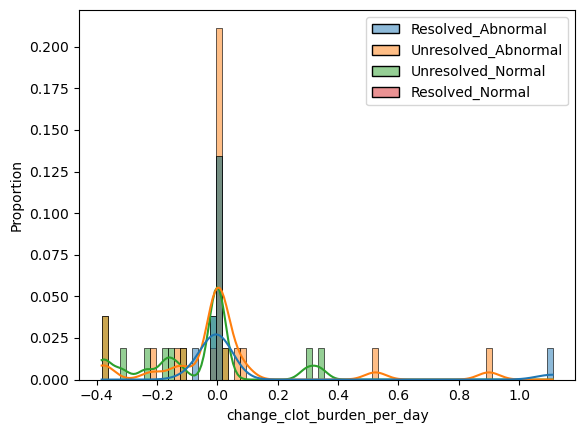

In [170]:
groupings = df['resolved_pe'].astype(str) + '_' + df['normal'].astype(str).map({'0': 'Abnormal', '1': 'Normal'})

sns.histplot(
	data=clot_burden_progression,
	x='change_clot_burden_per_day',
	hue=groupings,
	kde=True,
	stat='proportion',
	common_norm=True,
	kde_kws={'bw_adjust': 0.25}
)

plt.show()

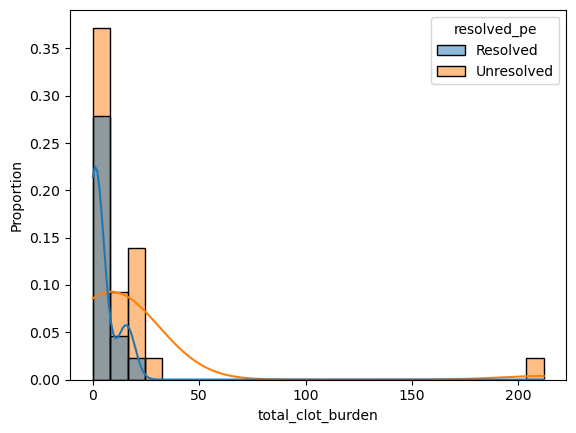

In [171]:
initial_obs = df.loc[df['pe_obs']==0, :]
initial_obs = initial_obs.dropna(subset='resolved_pe')

sns.histplot(
	data=initial_obs,
	x='total_clot_burden',
	hue='resolved_pe',
	kde=True,
	stat='proportion',
	common_norm=True,
	# kde_kws={'bw_adjust': 1.}
)

plt.show()

# data = [group_data['total_clot_burden'] for _, group_data in initial_obs.groupby('resolved_pe')]
# print(stats.mannwhitneyu(data[0], data[1]))
# print(stats.ttest_ind(data[0], data[1], equal_var=False))
# print(stats.ranksums(data[0], data[1]))

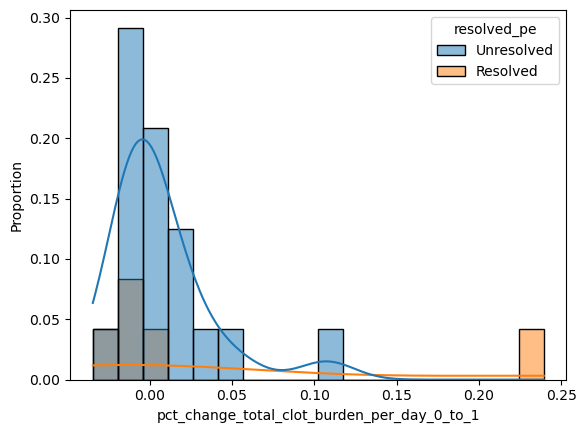

MannwhitneyuResult(statistic=37.0, pvalue=0.48922454357236966)
Ttest_indResult(statistic=0.576796871222641, pvalue=0.5939226098480122)
RanksumsResult(statistic=-0.7463595859764565, pvalue=0.4554502256326891)


In [172]:
df0 = num_data_initial.groupby(['PE_number', 'resolved_pe'])[['pct_change_total_clot_burden_per_day_0_to_1']].mean().dropna()

sns.histplot(
	data=df0,
	x='pct_change_total_clot_burden_per_day_0_to_1',
	hue='resolved_pe',
	kde=True,
	stat='proportion',
	common_norm=True,
	# kde_kws={'bw_adjust': 1.}
)

plt.show()

data = [group_data['pct_change_total_clot_burden_per_day_0_to_1'] for _, group_data in df0.groupby('resolved_pe')]
print(stats.mannwhitneyu(data[0], data[1]))
print(stats.ttest_ind(data[0], data[1], equal_var=False))
print(stats.ranksums(data[0], data[1]))

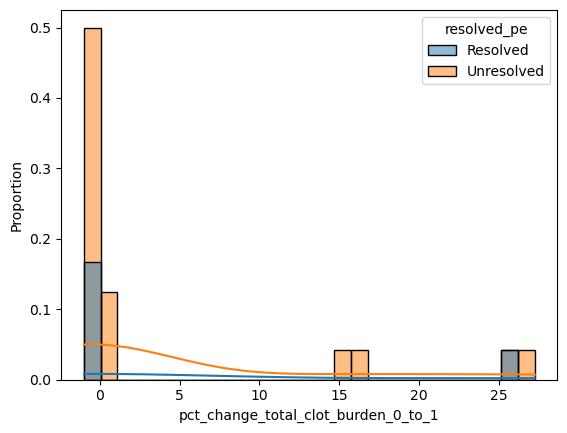

4.447689880768846
3.986497107091849
MannwhitneyuResult(statistic=35.0, pvalue=0.40556182947487296)
Ttest_indResult(statistic=0.08074144468592512, pvalue=0.9385573684040278)
RanksumsResult(statistic=-0.8885233166386386, pvalue=0.3742593192802244)


In [174]:
max_clot_burden = df.groupby(['PE_number', 'resolved_pe'])[['pct_change_total_clot_burden_0_to_1']].mean().dropna()

sns.histplot(
	data=max_clot_burden,
	x='pct_change_total_clot_burden_0_to_1',
	hue='resolved_pe',
	kde=True,
	stat='proportion',
	common_norm=True,
	# kde_kws={'bw_adjust': 1.}
)

plt.show()

data = [group_data['pct_change_total_clot_burden_0_to_1'] for _, group_data in max_clot_burden.groupby('resolved_pe')]
print(data[0].mean())
print(data[1].mean())
print(stats.mannwhitneyu(data[0], data[1]))
print(stats.ttest_ind(data[0], data[1], equal_var=False))
print(stats.ranksums(data[0], data[1]))

In [175]:
long_term = df.loc[(df['total_visits']>1) & (df['long_term_obs']), :]
short_term = df.loc[(df['total_visits']>1) & (~df['long_term_obs']), :]

print(long_term.shape)
print(short_term.shape)

long_term.head()

(54, 475)
(30, 475)


,pe_study_number,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,previous_clot_burden,previous_study_date,pct_change_clot_burden,duration_prev_to_t_days,change_clot_burden_per_day,max_days_from_first_visit,long_term_obs,max_clot_burden,max_clot_burden_category,PE_number_num
PE15_0,PE15,HB046618,F,3.0,315.0,0.0000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaT,NaN,NaN,NaN,892.0,True,180.785865,80-100 percentile,15.0
PE15_1,PE15,HB046618,F,3.0,323.0,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.212129,2028-01-31,-0.974267,206.0,-0.001003,892.0,True,180.785865,80-100 percentile,15.0
PE15_2,PE15,HB046618,F,3.0,110.0,79.8595,4.500810,7.047200,3.872850,4.188950,...,0.005459,2028-08-24,33117.789055,201.0,0.899405,892.0,True,180.785865,80-100 percentile,15.0
PE15_3,PE15,HB046618,F,2.0,383.0,0.0000,0.000000,0.000000,0.000000,0.000000,...,180.785865,2029-03-13,-0.999956,485.0,-0.372738,892.0,True,180.785865,80-100 percentile,15.0
PE18_0,PE18,HB046621,F,4.0,228.0,11.1269,0.969794,0.113678,0.000642,0.210015,...,NaN,NaT,NaN,NaN,NaN,2308.0,True,327.569044,80-100 percentile,18.0


## Progression Scatter Plot

C:\Users\qauster\AppData\Local\Temp\ipykernel_16588\3600600158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  progression_data['heights'] = (


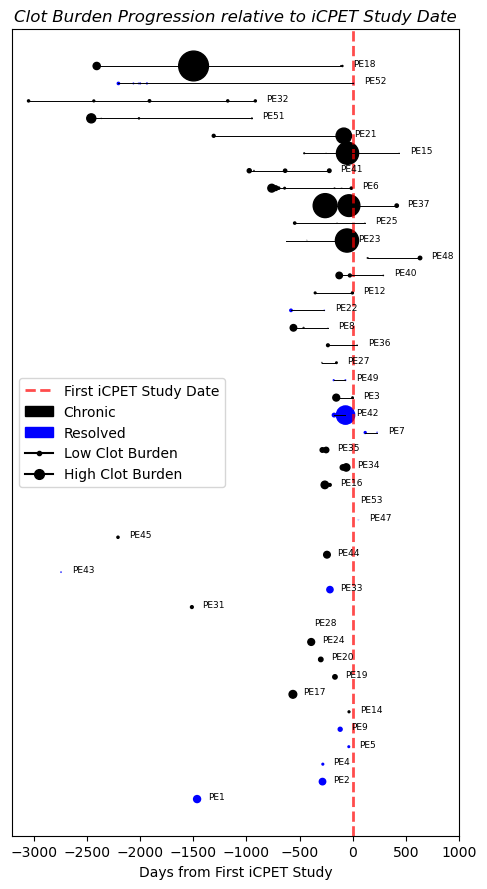

In [176]:
# Get complete progression data
# Use ranking system based on max date range to determine graphing heights
progression_data = df.dropna(subset=['duration_t_to_iCPET_days', 'PE_number_num', 'total_clot_burden'])
progression_data['heights'] = (
	progression_data['date_range'] + progression_data['PE_number_num']
).transform(lambda x: x.rank(method='dense'))
progression_data = progression_data.sort_values(by=['heights', 'pe_obs'], ascending=False)

# Create color mapping for resolved/unresolved
color_mapping = {'Resolved': 'blue', 'Unresolved': 'black'}

# Plot figure
fig, axs = plt.subplots(figsize=(5, 9))

# Plot vertical line representing iCPET study date
vline = axs.axvline(
	x = 0, linestyle='--', linewidth=2.0, color = 'red', 
	alpha=0.7, label = 'First iCPET Study Date'
)

for patient_label, patient_data in progression_data.groupby('PE_number_num', as_index=False, sort=True):
	lines = axs.plot(
		patient_data['duration_t_to_iCPET_days'], 
		patient_data['heights'], 
		c='black', linewidth=0.7
	)
	annot_x = patient_data['duration_t_to_iCPET_days'][0]
	annot_y = patient_data['heights'][0]
	annot_x_offset = 100.
	annotation = plt.annotate(
		f'PE{str(int(patient_label))}', xy=(annot_x + annot_x_offset, annot_y), 
		xytext=(annot_x + annot_x_offset, annot_y),
		fontsize=6.5
	)

# Can plot all scatter data together (helps for legend)
scatter = axs.scatter(
	progression_data['duration_t_to_iCPET_days'], 
	progression_data['heights'], 
	c=progression_data['resolved_pe'].map(color_mapping).astype(str), 
	s=progression_data['total_clot_burden'] * 1.4, 
	label='Clot Burden'
)
	
# Labeling
plt.title('Clot Burden Progression relative to iCPET Study Date', fontstyle='oblique')
plt.xlabel('Days from First iCPET Study')

# Removing y-axis ticks and labels
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlim([-3200, 1000])

# Set legend to display the scale of point sizes
black_patch = mpatches.Patch(color='black', label='Chronic')
blue_patch = mpatches.Patch(color='blue', label='Resolved')
small_mark = mlines.Line2D(
	[], [], color='black', marker='o',
	markersize=3, label='Low Clot Burden'
)
large_mark = mlines.Line2D(
	[], [], color='black', marker='o',
	markersize=7, label='High Clot Burden'
)

my_handles = [vline, black_patch, blue_patch, small_mark, large_mark]

legend = plt.legend(loc='center left', handles=my_handles)

# Save and plot
plt.tight_layout()
plt.savefig('../figures/clot_burden_progressions.png')
plt.show()

In [177]:
# Use to spot check accuracy of figure
df.loc[df['PE_number_num']==8, ['duration_t_to_iCPET_days', 'total_clot_burden', 'resolved_pe']]

,duration_t_to_iCPET_days,total_clot_burden,resolved_pe
PE8_0,-559.0,15.608278,Unresolved
PE8_1,-464.0,0.193119,Unresolved
PE8_2,-236.0,0.003576,Unresolved


# Correlations

In [178]:
dead_space_features = [
    've_vco2_slope',
    've_vco2_at_at',
    'peak_vd_vt'
]
hemodynamic_features = [
    'mpap_co_ratio',
    'peak_measured_mpap_mmhg',
    'peak_pvr_wu',
    'peak_pa_elastance_ea_mmhg_ml_m2',
    'hyperventilation_num'
]

radiology_features = [
    'total_clot_burden',
    'num_positive_clot_burden_segments',
    'pct_change_total_clot_burden_0_to_1',
]

correlation_features = dead_space_features + hemodynamic_features + radiology_features
rows = radiology_features
cols = dead_space_features + hemodynamic_features

initial_correlation_data = num_data_initial.loc[num_data_initial['total_clot_burden'] < 50, correlation_features]
initial_correlation_data.corr().loc[rows, cols].sort_index().to_csv('../output/summary/corr_initial.csv')

last_prior_correlation_data = num_data_last_prior.loc[num_data_last_prior['total_clot_burden'] < 50, correlation_features]
last_prior_correlation_data.corr().loc[rows, cols].sort_index().to_csv('../output/summary/corr_last_prior_to_icpet.csv')

In [179]:
print(f"n={num_data_initial.shape[0]} for initial CTA") 

n=49 for initial CTA


In [180]:
df.filter(regex='slope').columns

Index(['ve_vco2_slope', 'vo2_work_slope_output'], dtype='object')

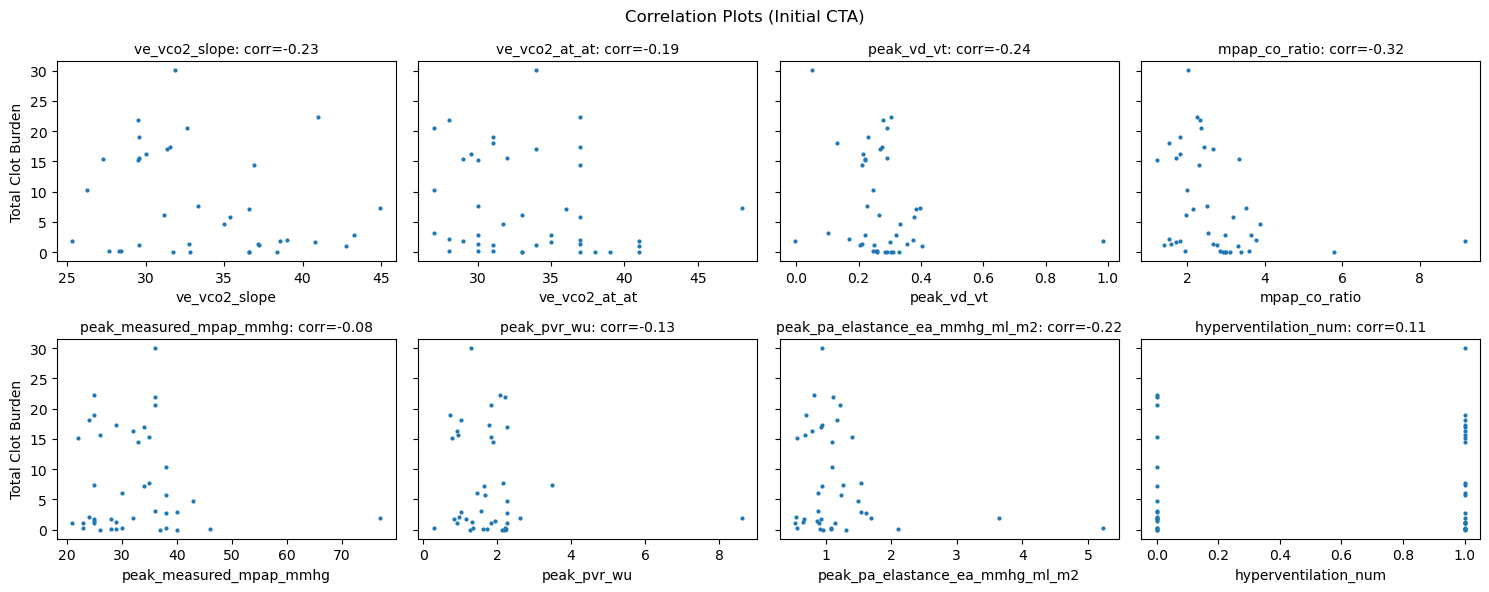

In [181]:
icpet_feat = dead_space_features + hemodynamic_features
n_rows = 2
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6), sharey=True)
for i, feat in enumerate(icpet_feat):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].scatter(feat, 'total_clot_burden', data=initial_correlation_data, s=4)
    p = initial_correlation_data[['total_clot_burden', feat]].corr().iloc[1, 0]
    axs[row, col].set_title(f"{feat}: corr={p:.2f}", fontsize=10)
    axs[row, col].set_xlabel(feat)
    if col == 0:
        axs[row, col].set_ylabel('Total Clot Burden')
plt.suptitle('Correlation Plots (Initial CTA)')
plt.tight_layout()
plt.savefig('../figures/correlations_initial.png')

In [182]:
num_data_initial.loc[num_data_initial['total_clot_burden'] > 50, 'PE_number']

26    PE37
Name: PE_number, dtype: object

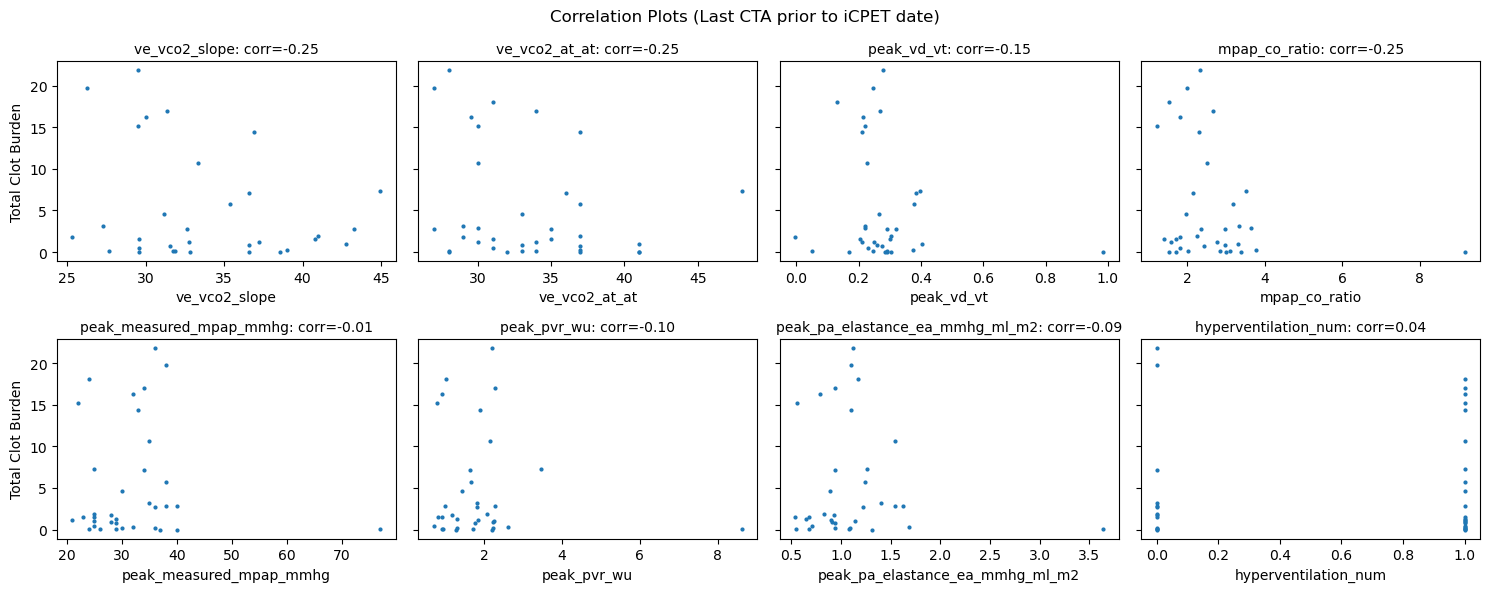

In [183]:
icpet_feat = dead_space_features + hemodynamic_features
n_rows = 2
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6), sharey=True)
for i, feat in enumerate(icpet_feat):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].scatter(feat, 'total_clot_burden', data=last_prior_correlation_data, s=4)
    p = last_prior_correlation_data[['total_clot_burden', feat]].corr().iloc[1, 0]
    axs[row, col].set_title(f"{feat}: corr={p:.2f}", fontsize=10)
    axs[row, col].set_xlabel(feat)
    if col == 0:
        axs[row, col].set_ylabel('Total Clot Burden')
plt.suptitle('Correlation Plots (Last CTA prior to iCPET date)')
plt.tight_layout()
plt.savefig('../figures/correlations_last_prior.png')

In [184]:
num_data_last_prior.loc[num_data_last_prior['total_clot_burden'] > 50, 'PE_number']

3     PE15
10    PE21
12    PE23
24    PE37
28    PE42
Name: PE_number, dtype: object